# Tropical Cyclone Wind Estimation from Satellite Imagery

By: Ali Ahmadalipour, Principal Data Scientist at KatRisk

To check out a summary of the methodology and results, please visit https://www.linkedin.com/pulse/deep-learning-computer-vision-satellite-imagery-ali-ahmadalipour/

# 1. Import data and unzip

For this presentation, we will skip running this part, since I have alreay downloaded and preprocessed the data.

In [1]:
import os
import requests
import tarfile
import urllib.request

### Download data using Radiant MLHub:

In [ ]:
# pip install radiant_mlhub

In [ ]:
from radiant_mlhub import Dataset, Collection, client
#os.environ['MLHUB_API_KEY'] = 'YOUR_MLHub_API_KEY'

In [ ]:
dataset = Dataset.fetch('nasa_tropical_storm_competition')
download_dir = Path('./').resolve()
archive_paths = dataset.download(output_dir=download_dir)
#print('Download completed')

### Check the number of files to ensure correct extraction

In [ ]:
## Count the number of files to make sure that all files are correctly loaded and extracted:
#directory ='.'
#path, dirs, files = next(os.walk(directory+'/train'))
#file_count = len(files)
#file_count #70257

# 2. Preprocessing data:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import time
%matplotlib inline

In [2]:
# To load the data from the shared Google drive, open the shared drive in your browser,
# right click on the folder, and select "Add shortcut to Drive". Now you should see it on your Google Drive.
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
directory ='/content/drive/MyDrive/Lecture_10/' 
train_metadata  = pd.read_csv(f'{directory}/training_set_features.csv')
train_labels = pd.read_csv(f'{directory}/training_set_labels.csv')
#directory = '.'

In [3]:
train_metadata.head()

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2


In [4]:
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


In [5]:
# to check if everything loaded fine
train_metadata.storm_id.nunique()

494

In [6]:
full_metadata = train_metadata.merge(train_labels, on="image_id")

In [7]:
full_metadata['file_name'] = full_metadata.image_id.apply(lambda x: f'{directory}/train/{x}.jpg')

In [8]:
full_metadata.head()

,image_id,storm_id,relative_time,ocean,wind_speed,file_name
0,abs_000,abs,0,2,43,./train/abs_000.jpg
1,abs_001,abs,1800,2,44,./train/abs_001.jpg
2,abs_002,abs,5400,2,45,./train/abs_002.jpg
3,abs_003,abs,17999,2,52,./train/abs_003.jpg
4,abs_004,abs,19799,2,53,./train/abs_004.jpg


image shape= (366, 366)


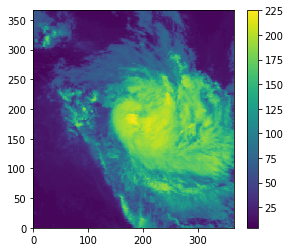

In [9]:
# load a single image and see how it is:
img = mpimg.imread(f'{directory}/sample_img_abs_010.jpg')
print('image shape=',img.shape)
plt.figure(figsize=[4.5,4])
plt.pcolor(img)
plt.colorbar()

In [10]:
def resize_crop_img(img):
    # The function takes an array of a 366x366 image and converts it to a 64x64 shape.
    # The input array for this exercise should be 366x366.
    #----------------------------------------------
    new_img_size = 256
    # 1. Cropping a 256x256 size array that has the highest values (i.e the eye of cyclone and its surrounding)
    n_passes = img.shape[0] - new_img_size
    slice_avg = np.array([[img[row:row+new_img_size,col:col+new_img_size].mean() \
                           for col in range(n_passes)] for row in range(n_passes)])
    max_index = np.unravel_index(slice_avg.argmax(), slice_avg.shape)
    img_crop = img[max_index[0]:max_index[0]+new_img_size, max_index[1]:max_index[1]+new_img_size]
    # 2. Reshaping the array from 256x256 to 64x64 (same as using a MaxPool2D with size=(2,2) and stride=2)
    img_crop_resize = img_resize = img_crop.reshape(64, 4, 64, 4).max(-1).max(1)

    # another way to do the above but using tensorflow. This is much slower. 
    # One can also consider using opencv for this part, as that library is very efficient for image processing.
    """
    average_pool_2d = tf.keras.layers.AveragePooling2D(pool_size=(new_img_size, new_img_size), 
                                                       strides=(1, 1))
    max_pool_2d = tf.keras.layers.MaxPool2D(pool_size=(4, 4), 
                                                       strides=(1, 1))
    x = tf.constant(np.trunc(img))
    slice_avg = average_pool_2d(tf.reshape(x, [1, 366, 366, 1]))
    slice_avg = np.array(slice_avg[0,:,:,0]).reshape(111,111)
    img_crop = x[max_index[1]:max_index[1]+new_img_size, max_index[2]:max_index[2]+new_img_size]
    img_crop_resize = max_pool_2d(tf.reshape(x, [1, 256, 256, 1]))
    """

    return img_crop_resize

Original image shape= (366, 366)
Resized image shape= (64, 64)


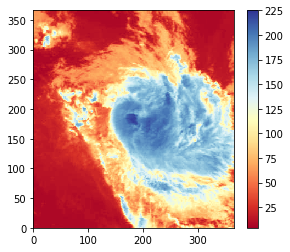

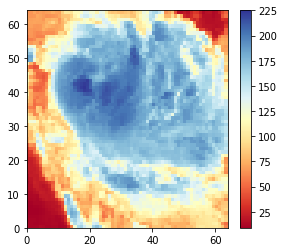

In [11]:
# load a single image and see how the resizing works:
img = mpimg.imread(f'{directory}/sample_img_abs_010.jpg')
print('Original image shape=',img.shape)
plt.figure(figsize=[4.5,4])
plt.pcolor(img, cmap='RdYlBu')
plt.colorbar()
plt.figure(figsize=[4.5,4])
plt.pcolor(resize_crop_img(img), cmap='RdYlBu')
print('Resized image shape=',resize_crop_img(img).shape)
plt.colorbar();

In [12]:
# Add a temporary column for number of images per storm
images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")

In [13]:
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
full_metadata["pct_of_storm"] = (
    full_metadata.groupby("storm_id").cumcount() / full_metadata.images_per_storm
)
train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)

In [14]:
train.head(2)

,image_id,storm_id,relative_time,ocean,wind_speed,file_name
0,abs_000,abs,0,2,43,./train/abs_000.jpg
1,abs_001,abs,1800,2,44,./train/abs_001.jpg


# 3. Resizing training data (only done if limited memory):

In [ ]:
# This part is only done to reduce input file size and to be able to run the code using limited memory 
# on Google Colab. If you are not limited with computation power, you can skip sections 3 & 4.

In [ ]:
def extract_data_chunk(i, period):
    chunk_size = 1000
    if period == 'train':
        if i == len(train)//chunk_size:
            x_train = np.stack(([resize_crop_img(mpimg.imread(train.file_name.iloc[x])/255) \
                                 for x in range(chunk_size*i,len(train))]),
                               axis=2).transpose(2, 0, 1).reshape(chunk_size*i-len(train),64,64,1)
        else:
            x_train = np.stack(([resize_crop_img(mpimg.imread(train.file_name.iloc[x])/255) \
                                for x in range(chunk_size*i,chunk_size*(i+1))]),
                               axis=2).transpose(2, 0, 1).reshape(chunk_size,64,64,1)
        np.save(f'{directory}/chunks/x_train_part_{i:03.0f}.npy',
                x_train, allow_pickle=False)

    elif period == 'val':
        if i == len(val)//chunk_size:
            x_val = np.stack(([resize_crop_img(mpimg.imread(val.file_name.iloc[x])/255) \
                               for x in range(chunk_size*i,len(val))]),
                             axis=2).transpose(2, 0, 1).reshape(chunk_size*i-len(val),64,64,1)
        else:
            x_val = np.stack(([resize_crop_img(mpimg.imread(val.file_name.iloc[x])/255) \
                                for x in range(chunk_size*i,chunk_size*(i+1))]),
                             axis=2).transpose(2, 0, 1).reshape(chunk_size,64,64,1)
        np.save(f'{directory}/chunks/x_val_part_{i:03.0f}.npy',
                x_val, allow_pickle=False)

In [ ]:
for i in range(14):
    extract_data_chunk(i, period='val')
for i in range(57):
    extract_data_chunk(i, period='train')

In [ ]:
# Stacking images
dir_str = f'{directory}/chunks'
x_train = np.concatenate(([np.load(f'{dir_str}/x_train_part_{i:03.0f}.npy') for i in range(57)]),
                    axis=0)
x_val = np.concatenate(([np.load(f'{dir_str}/x_val_part_{i:03.0f}.npy') for i in range(14)]),
                    axis=0)

In [ ]:
x_train.shape, x_val.shape

In [ ]:
len(train), len(val)

In [ ]:
y_train = train.wind_speed.iloc[:len(x_train)].values
y_val = val.wind_speed.iloc[:len(x_val)].values

In [ ]:
y_train.shape, y_val.shape

In [ ]:
#np.save(f'{directory}/x_train.npy',
#                x_train, allow_pickle=False)
#np.save(f'{directory}/x_val.npy',
#                x_val, allow_pickle=False)

# 4. Reshaping test data (only done if limited memory):

In [ ]:
test_metadata  = pd.read_csv(f'{directory}/test_set_features.csv')

In [ ]:
test_metadata['file_name'] = test_metadata.image_id.apply(lambda x: f'{directory}/test/{x}.jpg')
test_metadata.head(3)

In [ ]:
len(test_metadata)

In [ ]:
def extract_testdata_chunk(i, test_metadata):
    chunk_size = 1000
    if i == len(test_metadata)//chunk_size:
        x_test = np.stack(([resize_crop_img(mpimg.imread(test_metadata.file_name.iloc[x])/255) \
                              for x in range(chunk_size*i,len(test_metadata))]),
                            axis=2).transpose(2, 0, 1).reshape(chunk_size*i-len(test_metadata),64,64,1)
    else:
        x_test = np.stack(([resize_crop_img(mpimg.imread(test_metadata.file_name.iloc[x])/255) \
                            for x in range(chunk_size*i,chunk_size*(i+1))]),
                            axis=2).transpose(2, 0, 1).reshape(chunk_size,64,64,1)
    np.save(f'{directory}/chunks/x_test_part_{i:03.0f}.npy',
            x_test, allow_pickle=False)

In [ ]:
for i in range(45):
    start_time = time.time()
    extract_testdata_chunk(i, test_metadata)
    print(f'Part {i} is done!')
    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Stacking images
dir_str = f'{directory}/chunks'
x_test = np.concatenate(([np.load(f'{dir_str}/x_test_part_{i:03.0f}.npy') for i in range(45)]),
                    axis=0)

In [ ]:
x_test.shape

In [ ]:
#np.save(f'/content/drive/MyDrive/Colab Notebooks/AI_4_wind/Data/x_test.npy',
#                x_test, allow_pickle=False)

# 5. Rotating and duplicating low frequency images

'''
To load the data from the shared Google drive, open the shared drive, right click on the folder, and select "Add shortcut to Drive" and select My Drive. You will then be able to access and load the data in Google Colab.
'''

In [15]:
x_train = np.load('/content/drive/MyDrive/Lecture_10/x_train.npy')
x_val = np.load('/content/drive/MyDrive/Lecture_10/x_val.npy')
y_train = train.wind_speed.iloc[:len(x_train)].values
y_val = val.wind_speed.iloc[:len(x_val)].values

In [16]:
x_train.shape, x_val.shape

((56392, 64, 64, 1), (13865, 64, 64, 1))

In [17]:
y_train.shape, y_val.shape

((56392,), (13865,))

In [18]:
# For data augmentation and rotating input images, I am only focusing on the images corresponding to wind speeds
# above 40. The value 40 is an arbitrary value to make sure that the code is still able to be run on Google Colab.
train_highwind = train.reset_index(drop=True)[train.reset_index(drop=True).wind_speed>40]
#train_highwind.head()

In [19]:
x_highwind = x_train[train_highwind.index,:,:,:]
y_highwind = y_train[train_highwind.index]
x_highwind_rot1 = np.rot90(x_highwind, axes=(1,2))
x_highwind_rot2 = np.rot90(x_highwind, 2, axes=(1,2))
x_highwind_rot3 = np.rot90(x_highwind, 3, axes=(1,2))

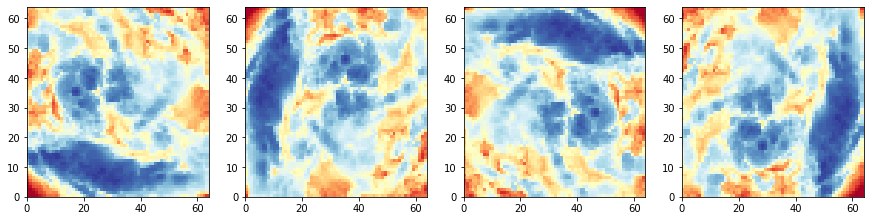

In [20]:
# Sample plot for rotating: 
plt.figure(figsize=[15,3.5])
plt.subplot(141)
plt.pcolor(x_highwind[0,:,:,0], cmap='RdYlBu')
plt.subplot(142)
plt.pcolor(x_highwind_rot1[0,:,:,0],cmap='RdYlBu')
plt.subplot(143)
plt.pcolor(x_highwind_rot2[0,:,:,0],cmap='RdYlBu')
plt.subplot(144)
plt.pcolor(x_highwind_rot3[0,:,:,0],cmap='RdYlBu')

In [21]:
x_train_extra = np.concatenate((x_train,x_highwind_rot1,x_highwind_rot2,x_highwind_rot3), axis=0)
y_train_extra = np.concatenate((y_train,y_highwind,y_highwind,y_highwind), axis=0)

In [22]:
x_train.shape, x_train_extra.shape

((56392, 64, 64, 1), (150646, 64, 64, 1))

In [23]:
y_train.shape, y_train_extra.shape

((56392,), (150646,))

# 6. Developing the CNN model:

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping#, ModelCheckpoint
#from tensorflow.keras.optimizers import SGD
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [25]:
alpha = 0.0001
padding = 'same' #'valid'
activation = partial(tf.nn.leaky_relu, alpha=alpha) #'relu'
optimizer = 'adam' #SGD(learning_rate=0.01)

model = Sequential()
#first layer
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(64, 64, 1), 
                activation=activation, padding=padding))
model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))
model.add(Dropout(0.35))
# second layer
model.add(Conv2D(filters=128, kernel_size=(2,2), activation=activation))
model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))
model.add(Dropout(0.3))
# third layer
model.add(Conv2D(filters=256, kernel_size=(2,2), activation=activation))
model.add(MaxPool2D(pool_size=(2, 2), padding=padding))
model.add(Dropout(0.3))
# fourth layer
model.add(Conv2D(filters=256, kernel_size=(2,2), activation=activation))
model.add(MaxPool2D(pool_size=(2, 2), padding=padding))
model.add(Dropout(0.3))
# fifth layer
model.add(Conv2D(filters=512, kernel_size=(2,2), activation=activation))
model.add(Dropout(0.3))
# sixth layer
model.add(Conv2D(filters=512, kernel_size=(2,2), activation=activation))
model.add(Dropout(0.3))
# Dense layer
model.add(Flatten())
model.add(Dense(1024, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(1024, activation=activation))
model.add(Dropout(0.25))
model.add(Dense(1, activation=activation))

model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

#model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
#model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 128)       32896     
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       1

In [27]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [28]:
del x_train #to make the memory available for training the model

# 7. Model fitting:

In [30]:
model.fit(x_train_extra,y_train_extra,epochs=30,validation_data=(x_val,y_val), batch_size=900)
#model.fit(x_train_extra,y_train_extra,epochs=15,validation_data=(x_val,y_val), batch_size=1000,callbacks=[earlyStopping, mcp_save])

Epoch 1/30
168/168 [==============================] - 100s 371ms/step - loss: 1143.1372 - accuracy: 0.0000e+00 - val_loss: 541.6284 - val_accuracy: 0.0000e+00
Epoch 2/30
168/168 [==============================] - 60s 356ms/step - loss: 643.2888 - accuracy: 0.0000e+00 - val_loss: 529.9421 - val_accuracy: 0.0000e+00
Epoch 3/30
168/168 [==============================] - 59s 353ms/step - loss: 621.3803 - accuracy: 0.0000e+00 - val_loss: 343.9056 - val_accuracy: 0.0000e+00
Epoch 4/30
168/168 [==============================] - 59s 353ms/step - loss: 589.9660 - accuracy: 0.0000e+00 - val_loss: 323.5196 - val_accuracy: 0.0000e+00
Epoch 5/30
168/168 [==============================] - 59s 353ms/step - loss: 537.3095 - accuracy: 0.0000e+00 - val_loss: 347.6053 - val_accuracy: 0.0000e+00
Epoch 6/30
168/168 [==============================] - 59s 354ms/step - loss: 423.7458 - accuracy: 0.0000e+00 - val_loss: 270.2244 - val_accuracy: 0.0000e+00
Epoch 7/30
168/168 [==============================] - 59

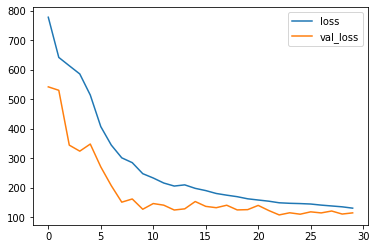

In [31]:
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

In [29]:
# Loading the pretrained model (if already available):
model.load_weights(f'{directory}') 

In [30]:
predictions = model.predict(x_val)

In [31]:
preds = pd.DataFrame(y_val.reshape(-1,1), columns=['truth'])
preds['model'] = predictions
preds.head()

,truth,model
0,51,47.167343
1,50,46.740452
2,50,46.004353
3,50,43.432323
4,50,42.032333


In [32]:
preds['diff'] = abs(preds['truth']-preds['model'])

In [33]:
val['prediction'] = preds.model.values.astype(int)
val = val.drop(columns=['file_name'])
# val.to_csv('prediction_val_Radiant.csv')

In [34]:
round(mean_squared_error(preds.model, preds.truth, squared=False),2)

10.68

In [35]:
round(mean_absolute_error(preds.truth,preds.model),2)

7.94

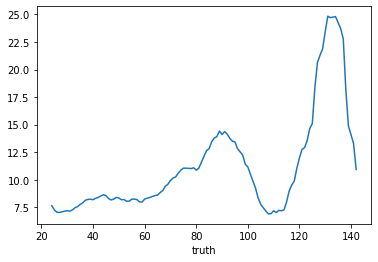

In [36]:
preds.groupby('truth').mean()['diff'].rolling(window=10).mean().plot()

# 8. Prediction for test period:

In [43]:
# we need to delete the training data and release memory to be able to run the model for test period.
del x_train_extra

In [44]:
x_test = np.load(f'{directory}/x_test.npy')
test_metadata  = pd.read_csv(f'{directory}/test_set_features.csv')

In [45]:
test_pred = model.predict(x_test)
test_pred.shape

(44377, 1)

In [47]:
test_metadata['prediction'] = test_pred[:,0]
test_metadata.to_csv('prediction_test_Radiant.csv')

In [48]:
test_metadata['wind_speed'] = test_metadata.prediction.apply(lambda x: round(x))

In [49]:
#saving submission
test_metadata[['image_id','wind_speed']].set_index('image_id').to_csv('Submission_Radiant.csv')

# 9. Saving the model:

In [65]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

#json_config = model.to_json()
#new_model = keras.models.model_from_json(json_config)

In [70]:
directory

'/content/drive/MyDrive/Colab Notebooks/AI_4_wind/Predictions'

In [72]:
model.save_weights(".")